In [2]:
import sys
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
import pandas as pd
import numpy as np

os.chdir("/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/hybridretrieval/acdc_results/kbicr_indirect_kl_div_0.05/logs")
os.getcwd()

'/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/hybridretrieval/acdc_results/kbicr_indirect_kl_div_0.05/logs'

# ROC curve

more info: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Unique true labels: [0 1]
True labels distribution: [282 282]
Predicted scores range: -0.07112351059913635 - 4.01619166135788
Predicted scores mean: 0.027927465566452942
True labels: [0 0 0 0 0]
Predicted scores: [0.10277948 0.05343282 0.0015827  0.00123153 0.00012262]


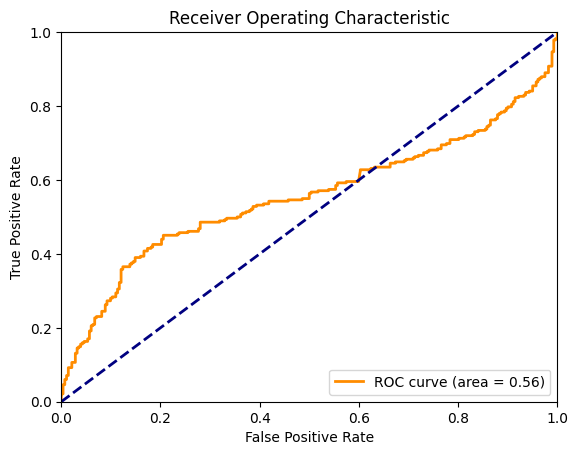

In [3]:
# Load metrics from the JSON file
with open('metrics.json', 'r') as f:
    metrics_data = json.load(f)

# Extract true labels and predicted scores
current_metrics = np.array(metrics_data['current_metrics'])
predicted_scores = np.array(metrics_data['results'])

# Ensure all values are numeric (already handled by converting to np.array)
# current_metrics = pd.to_numeric(current_metrics)
# predicted_scores = pd.to_numeric(predicted_scores)

# Determine a threshold to create binary labels (using median here for example)
threshold = np.median(current_metrics)
true_labels = (current_metrics >= threshold).astype(int)

# Check unique values in true_labels
unique_labels = np.unique(true_labels)
print(f"Unique true labels: {unique_labels}")

# Print statistics for verification
print(f"True labels distribution: {np.bincount(true_labels)}")
print(f"Predicted scores range: {predicted_scores.min()} - {predicted_scores.max()}")
print(f"Predicted scores mean: {predicted_scores.mean()}")

# Check if true_labels and predicted_scores are aligned and correct
print(f"True labels: {true_labels[:5]}")
print(f"Predicted scores: {predicted_scores[:5]}")

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [4]:
unique_labels = pd.unique(true_labels)
print(f"Unique true labels: {unique_labels}")

Unique true labels: [0 1]


True labels distribution: [282 282]
Predicted scores range: -0.07112351059913635 - 4.01619166135788
Normalized predicted scores: [0.042547   0.03047388 0.01778826 0.01770234 0.01743103]


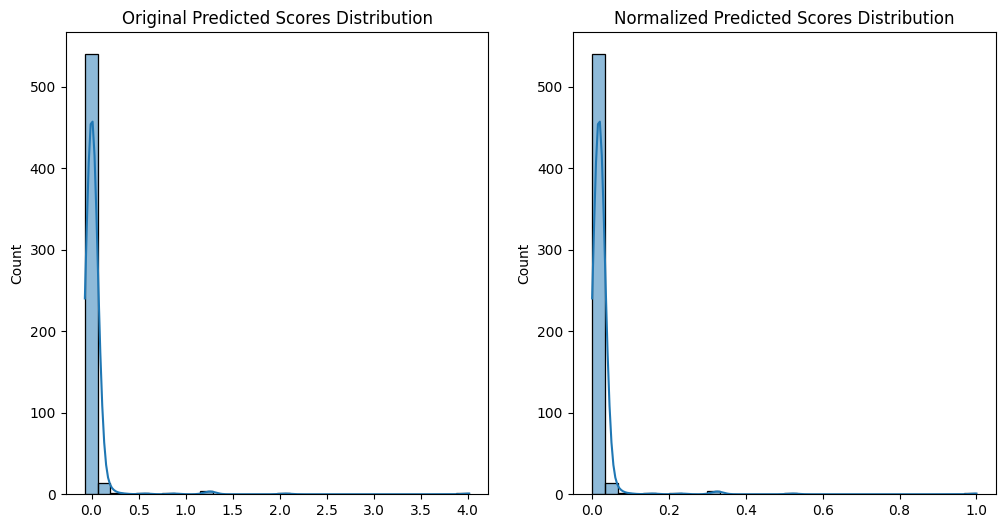

In [5]:
# Extract true labels and predicted scores
current_metrics = np.array(metrics_data['current_metrics'])
predicted_scores = np.array(metrics_data['results'])

# Ensure all values are numeric (already handled by converting to np.array)
# current_metrics = pd.to_numeric(current_metrics)
# predicted_scores = pd.to_numeric(predicted_scores)

# Determine a threshold to create binary labels (using median here for example)
threshold = np.median(current_metrics)
true_labels = (current_metrics >= threshold).astype(int)

# Normalize predicted scores to range [0, 1]
scaler = MinMaxScaler()
predicted_scores_normalized = scaler.fit_transform(predicted_scores.reshape(-1, 1)).flatten()

# Print statistics for verification
print(f"True labels distribution: {np.bincount(true_labels)}")
print(f"Predicted scores range: {predicted_scores.min()} - {predicted_scores.max()}")
print(f"Normalized predicted scores: {predicted_scores_normalized[:5]}")

# Plot the distribution of the original and normalized predicted scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(predicted_scores, kde=True, bins=30)
plt.title('Original Predicted Scores Distribution')

plt.subplot(1, 2, 2)
sns.histplot(predicted_scores_normalized, kde=True, bins=30)
plt.title('Normalized Predicted Scores Distribution')

plt.show()

# Precision-recall curve

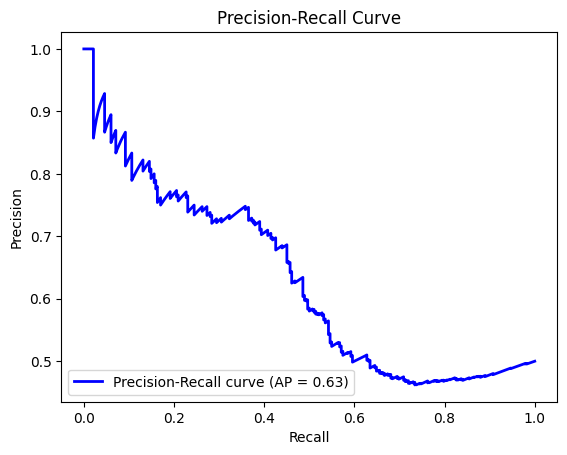

In [6]:
# Compute Precision-Recall curve and average precision score
precision, recall, _ = precision_recall_curve(true_labels, predicted_scores_normalized)
average_precision = average_precision_score(true_labels, predicted_scores_normalized)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        90
           1       0.59      0.59      0.59        80

    accuracy                           0.62       170
   macro avg       0.62      0.62      0.62       170
weighted avg       0.62      0.62      0.62       170

ROC AUC: 0.61
Average Precision: 0.57


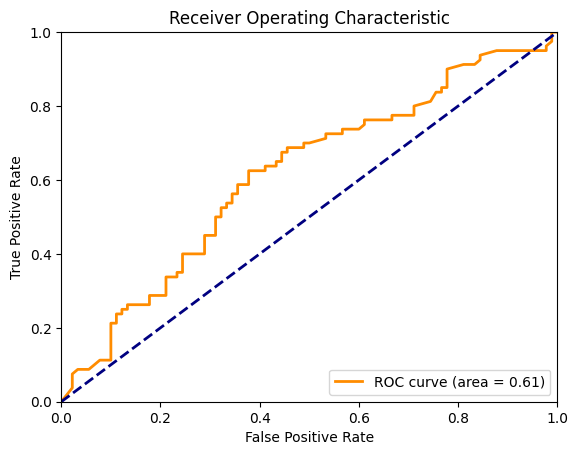

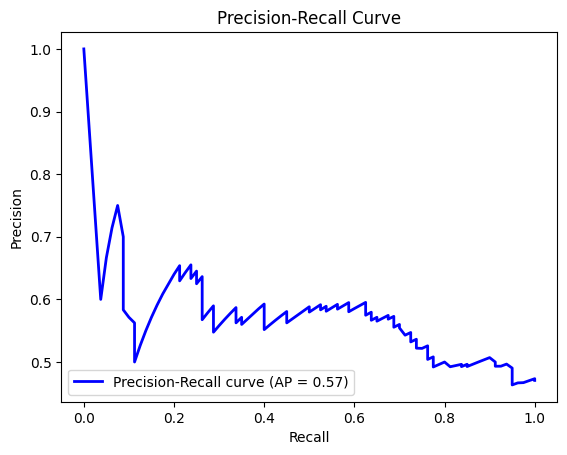

Feature ranking:
1. Feature 0 (1.0)


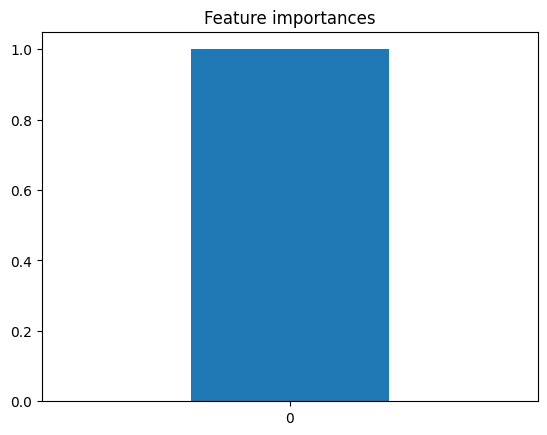

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

# Example data loading and preprocessing steps
# Load your dataset here
X = predicted_scores.reshape(-1, 1)
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='average_precision', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator from grid search
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.2f}')

# Compute Precision-Recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
print(f'Average Precision: {average_precision:.2f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Feature importance
feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({feature_importances[indices[f]]})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [11]:
import os 

os.chdir("/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/")

import collections
import IPython

if IPython.get_ipython() is not None:
    IPython.get_ipython().run_line_magic("load_ext", "autoreload")  # type: ignore
    IPython.get_ipython().run_line_magic("autoreload", "2")  # type: ignore

from copy import deepcopy
from subnetwork_probing.train import iterative_correspondence_from_mask
from acdc.acdc_utils import filter_nodes, get_edge_stats, get_node_stats, get_present_nodes, reset_network
import pandas as pd
import gc
import math
import sys
import re
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Optional,
    Union,
    Callable,
    TypeVar,
    Iterable,
    Set,
)
import requests
from acdc.TLACDCInterpNode import parse_interpnode, heads_to_nodes_to_mask
import pickle
import wandb
import IPython
from tqdm import tqdm
import random
from functools import partial
import json
import pathlib
import warnings
import time
import networkx as nx
import os
import torch
import huggingface_hub
import pygraphviz as pgv
from enum import Enum
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
from acdc.acdc_utils import (
    make_nd_dict,
    shuffle_tensor,
    cleanup,
    ct,
)

from acdc.TLACDCEdge import (
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from collections import defaultdict, deque, OrderedDict
from acdc.acdc_utils import (
    kl_divergence,
)

from acdc.acdc_graphics import (
    build_colorscheme,
    get_node_name,
    show,
)

from acdc.hybridretrieval.utils import ( 
    get_all_hybrid_retrieval_things,
    get_gpt2_small
)

import argparse
from pathlib import Path

from notebooks.emacs_plotly_render import set_plotly_renderer
set_plotly_renderer("emacs")


def get_col(df, col): # dumb util
    non_null_entries = list(df.loc[df[col].notnull(), col])
    return non_null_entries 

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import IPython
# from roc_plot_generator import get_acdc_runs, plot_roc_curve

parser = argparse.ArgumentParser(description="Used to control ROC plot scripts (for standardisation with other files...)")
parser.add_argument('--task', type=str, required=True, choices=['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'hybrid-retrieval'], help='Choose a task from the available options: ioi, docstring, induction, tracr-reverse, tracr-proportion, greaterthan')
parser.add_argument("--mode", type=str, required=False, choices=["edges", "nodes"], help="Choose a mode from the available options: edges, nodes", default="edges") # TODO implement nodes
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument("--alg", type=str, default="none", choices=["none", "acdc", "sp", "16h", "canonical"])
parser.add_argument("--skip-sixteen-heads", action="store_true", help="Skip the 16 heads stuff")
parser.add_argument("--skip-sp", action="store_true", help="Skip the SP stuff")
parser.add_argument("--testing", action="store_true", help="Use testing data instead of validation data")
parser.add_argument("--device", type=str, default="cpu")
parser.add_argument("--out-dir", type=str, default="DEFAULT")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=42, help="Random seed")
parser.add_argument("--canonical-graph-save-dir", type=str, default="DEFAULT")
parser.add_argument("--only-save-canonical", action="store_true", help="Only save the canonical graph")
parser.add_argument("--ignore-missing-score", action="store_true", help="Ignore runs that are missing score")

if IPython.get_ipython() is not None:
    args = parser.parse_args("--task=hybrid-retrieval --metric=kl_div --alg=acdc".split())
if not args.mode == "edges":
    raise NotImplementedError("Only edges mode is implemented for now")


if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
METRIC = args.metric
DEVICE = args.device
ZERO_ABLATION = True if args.zero_ablation else False
RESET_NETWORK = 1 if args.reset_network else 0
SKIP_ACDC = False
SKIP_SP = True if args.skip_sp else False
SKIP_SIXTEEN_HEADS = True if args.skip_sixteen_heads else False
SKIP_CANONICAL = True
TESTING = True if args.testing else False
ONLY_SAVE_CANONICAL = True if args.only_save_canonical else False

In [20]:
__file__ = "/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/hybridretrieval/roc/roc_plot_generator.py"
if args.out_dir == "DEFAULT":
    OUT_DIR = Path(__file__).resolve().parent / "roc_plots" / "plots_data"
    CANONICAL_OUT_DIR = Path(__file__).resolve().parent / "results" / "canonical_circuits"
else:
    OUT_DIR = Path(args.out_dir)
    CANONICAL_OUT_DIR = Path(args.canonical_graph_save_dir)
CANONICAL_OUT_DIR.mkdir(exist_ok=True, parents=True)

In [21]:
if args.alg != "none":
    SKIP_ACDC = False if args.alg == "acdc" else True
    SKIP_SP = False if args.alg == "sp" else True
    SKIP_SIXTEEN_HEADS = False if args.alg == "16h" else True
    SKIP_CANONICAL = False if args.alg == "canonical" else True
    OUT_FILE = OUT_DIR / f"{args.alg}-{args.task}-{args.metric}-{args.zero_ablation}-{args.reset_network}.json"

    if OUT_FILE.exists():
        print("File already exists, skipping")
        sys.exit(0)
else:
    OUT_FILE = None

In [23]:
if TASK == "hybrid-retrieval":
    num_examples = 20
    things = get_all_hybrid_retrieval_things(num_examples, DEVICE, METRIC, True)

else:
    raise NotImplementedError("TODO " + TASK)

if RESET_NETWORK:
    reset_network(TASK, DEVICE, things.tl_model)
    gc.collect()
    torch.cuda.empty_cache()

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
Clean Prompts:
Alice lives in France, Paris - Alice, John lives in Germany, Berlin - John, Peter lives in USA, Washington - Peter
Lucy lives in Turkey, Ankara - Lucy, Sara lives in Italy, Rome - Sara, Bob lives in Spain, Madrid - Bob
Tom lives in Canada, Toronto - Tom, Anna lives in Australia, Canberra - Anna, Michael lives in Japan, Tokyo - Michael
David lives in Brazil, Rio de Janeiro - David, Alice lives in France, Paris - Alice, Peter lives in Germany, Berlin - Peter
Sara lives in USA, Washington - Sara, Lucy lives in Turkey, Ankara - Lucy, Tom lives in Italy, Rome - Tom
John lives in Spain, Madrid - John, Michael lives in Canada, Toronto - Michael, Anna lives in Australia, Canberra - Anna
David lives in Japan, Tokyo - David, Sara lives in Brazil, Rio de Janeiro - Sara, Alice lives in France, Paris - Alice
Bob lives in Germany, Berlin - Bob, Peter lives in USA, Washington - Peter, Tom lives in Turkey, 

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

import gc
gc.collect()
torch.cuda.empty_cache()
USE_POS_EMBED = False

things.tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=things.tl_model,
    threshold=0.15,
    early_exit=SKIP_ACDC and SKIP_CANONICAL,
    using_wandb=False,
    zero_ablation=bool(ZERO_ABLATION),
    # Process very little data if just building the canonical graph
    ds=things.test_data[slice(1) if ONLY_SAVE_CANONICAL else slice(None)],
    ref_ds=things.test_patch_data[slice(1) if ONLY_SAVE_CANONICAL else slice(None)],
    metric=things.validation_metric,
    second_metric=None,
    verbose=True,
    use_pos_embed=USE_POS_EMBED,
    online_cache_cpu=False,
    corrupted_cache_cpu=False,
)
if not SKIP_ACDC and not ONLY_SAVE_CANONICAL:
    exp.setup_corrupted_cache()

max_subgraph_size = exp.corr.count_no_edges()

dict_keys(['blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.hook_mlp_in', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_q', 'blocks.11.hook_q_input', 'blocks.11.attn.hook_k', 'blocks.11.hook_k_input', 'blocks.11.attn.hook_v', 'blocks.11.hook_v_input', 'blocks.10.hook_mlp_out', 'blocks.10.hook_mlp_in', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_q', 'blocks.10.hook_q_input', 'blocks.10.attn.hook_k', 'blocks.10.hook_k_input', 'blocks.10.attn.hook_v', 'blocks.10.hook_v_input', 'blocks.9.hook_mlp_out', 'blocks.9.hook_mlp_in', 'blocks.9.attn.hook_result', 'blocks.9.attn.hook_q', 'blocks.9.hook_q_input', 'blocks.9.attn.hook_k', 'blocks.9.hook_k_input', 'blocks.9.attn.hook_v', 'blocks.9.hook_v_input', 'blocks.8.hook_mlp_out', 'blocks.8.hook_mlp_in', 'blocks.8.attn.hook_result', 'blocks.8.attn.hook_q', 'blocks.8.hook_q_input', 'blocks.8.attn.hook_k', 'blocks.8.hook_k_input', 'blocks.8.attn.hook_v', 'blocks.8.hook_v_input', 'blocks.7.hook_mlp_out', 'blocks.7.hook_ml

No edge 32923
Adding sender hooks...
Done corrupting things


In [70]:
CIRCUIT = {
    # These are the defined layers and heads for the new task based on your diagram and given task prompt
    "PEOPLE_LOC": [(0, 2), (0, 6), (1, 10)],  # Example nodes for people and locations
    "INFO": [(0, 4), (1, 1)],  # Example nodes for the information extracted
    "EARLY": [(0, None), (1, None), (2, None), (3, None)],
    "MID": [(5, 3), (6, 2), (7, 8), (8, 10), (9, 7)],
    "LATE": [(10, None), (11, None)],
}

GROUP_COLORS = {
    "PEOPLE_LOC": "#d7f8ee",
    "INFO": "#e7f2da",
    "EARLY": "#fee7d5",
    "MID": "#ececf5",
}

MLP_COLOR = "#f0f0f0"

def greaterthan_group_colorscheme():
    assert set(GROUP_COLORS.keys()) == set(CIRCUIT.keys())

    scheme = {
        "embed": "#cbd5e8",
        "<resid_post>": "#fff2ae",
    }

    for i in range(12):
        scheme[f"<m{i}>"] = MLP_COLOR

    for k, heads in CIRCUIT.items():
        for (layer, head) in heads:
            if head is None:
                scheme[f"<m{layer}>"] = GROUP_COLORS[k]
            else:
                for qkv in ["", "_q", "_k", "_v"]:
                    scheme[f"<a{layer}.{head}{qkv}>"] = GROUP_COLORS[k]
    return scheme

In [55]:
@dataclass(frozen=True)
class Conn:
    inp: str
    out: str
    qkv: tuple[str, ...]

def get_kbicr_true_edges(model):
    all_groups_of_nodes = [group for _, group in CIRCUIT.items()]
    all_nodes = [node for group in all_groups_of_nodes for node in group]
    assert len(all_nodes) == 16, len(all_nodes)

    nodes_to_mask = [
        TLACDCInterpNode(
            name=f"blocks.{layer_idx}.attn.hook_{letter}",
            index=TorchIndex([None, None, head_idx]),
            incoming_edge_type=EdgeType.DIRECT_COMPUTATION
        )
        for layer_idx in range(12)
        for head_idx in range(12)
        if (layer_idx, head_idx) not in all_nodes
        for letter in "qkv"
    ]

    from subnetwork_probing.train import iterative_correspondence_from_mask
    corr, _ = iterative_correspondence_from_mask(nodes_to_mask=nodes_to_mask, model=model)

    for layer_idx, head_idx in all_nodes:
        for letter in "qkv":
            edge_key = f"blocks.{layer_idx}.hook_{letter}_input"
            torch_index = TorchIndex([None, None, head_idx])
            if torch_index in corr.edges[edge_key]:
                edge_to = corr.edges[edge_key][torch_index]

                # Check and set presence of keys
                pre_key = f"blocks.0.hook_resid_pre"
                if TorchIndex([None]) in edge_to:
                    edge_to[pre_key][TorchIndex([None])].present = False

                for layer_from in range(layer_idx):
                    for head_from in range(12):
                        result_key = f"blocks.{layer_from}.attn.hook_result"
                        if TorchIndex([None, None, head_from]) in edge_to:
                            edge_to[result_key][TorchIndex([None, None, head_from])].present = False

                post_key = "blocks.11.hook_resid_post"
                result_key = f"blocks.{layer_idx}.attn.hook_result"
                if TorchIndex([None]) in corr.edges[post_key]:
                    corr.edges[post_key][TorchIndex([None])][result_key][torch_index].present = False

    return OrderedDict({
        (t[0], t[1].hashable_tuple, t[2], t[3].hashable_tuple): e.present
        for t, e in corr.all_edges().items() if e.present
    })

In [56]:
COLORSCHEME_FOR = collections.defaultdict(lambda: (lambda: "Pastel2"), {
    # "ioi": ioi_group_colorscheme,
    # "greaterthan": greaterthan_group_colorscheme,
    'hybridretrieval': greaterthan_group_colorscheme,
})

get_true_edges = partial(get_kbicr_true_edges, model=things.tl_model)

if TASK != "induction":
    d = {(d[0], d[1].hashable_tuple, d[2], d[3].hashable_tuple): False for d in exp.corr.all_edges()}
    d_trues = get_true_edges()
    # if ONLY_SAVE_CANONICAL and TASK == "ioi":
    #     # Remove non-adjacent layer connections
    #     def layer(name):
    #         return int(name.split(".")[1])

    #     for t in list(d_trues.keys()):
    #         if abs(layer(t[0]) - layer(t[2])) > 1:
    #             del d_trues[t]

    for k in d_trues:
        d[k] = True

    exp.load_subgraph(d)
    canonical_circuit_subgraph = deepcopy(exp.corr)
    for t in exp.corr.all_edges().keys():
        exp.corr.edges[t[0]][t[1]][t[2]][t[3]].present = True
    canonical_circuit_subgraph_size = canonical_circuit_subgraph.count_no_edges()

    # and reset the sugbgraph...
    for t, e in exp.corr.all_edges().items():
        exp.corr.edges[t[0]][t[1]][t[2]][t[3]].present = True

    for edge in canonical_circuit_subgraph.all_edges().values():
        edge.effect_size = 1.0  # make it visible

    if ONLY_SAVE_CANONICAL:
        colorscheme = COLORSCHEME_FOR[TASK]()
        g: pgv.AGraph = show(
            canonical_circuit_subgraph,
            fname=CANONICAL_OUT_DIR / f"{TASK}.gv",
            colorscheme=colorscheme,
            show_full_index=False,
            layout="neato" if TASK in ["ioi", "greaterthan"] else "dot",
        )

        show(
            canonical_circuit_subgraph,
            fname=CANONICAL_OUT_DIR / f"{TASK}_mlp.gv",
            colorscheme=colorscheme,
            show_full_index=False,
            remove_qkv=True,
        )

        if TASK in ["ioi", "greaterthan", "hybrid-retrieval"]:
            no_mlp = deepcopy(canonical_circuit_subgraph)
            for (n_to, _, n_from, _), e in no_mlp.all_edges().items():
                if "mlp" in n_to or "mlp" in n_from:
                    e.present = False
            show(
                no_mlp,
                fname=CANONICAL_OUT_DIR / f"{TASK}_heads_qkv.gv",
                colorscheme=colorscheme,
                show_full_index=False,
                remove_self_loops=True,
                remove_qkv=False,
                layout="dot",
            )
            show(
                no_mlp,
                fname=CANONICAL_OUT_DIR / f"{TASK}_heads.gv",
                colorscheme=colorscheme,
                show_full_index=False,
                remove_self_loops=True,
                remove_qkv=True,
                layout="dot",
            )

if ONLY_SAVE_CANONICAL:
    sys.exit(0)

Editing all edges...
Done!


In [57]:
@dataclass(frozen=True)
class AcdcRunCandidate:
    threshold: float
    steps: int
    # run: wandb.apis.public.Run
    score_d: dict
    corr: TLACDCCorrespondence

In [106]:
import json
import os
from collections import defaultdict
from dataclasses import dataclass
from typing import Any, Callable, Optional, Dict
from tqdm import tqdm
from copy import deepcopy
import torch

@dataclass(frozen=True)
class AcdcRunCandidate:
    threshold: float
    steps: int
    score_d: dict
    corr: TLACDCCorrespondence  # Replace with the actual type of TLACDCCorrespondence if known

def get_acdc_runs(
    exp,
    project_path: str,  # Local path to the project directory
    pre_run_filter: Optional[Callable[[str], bool]] = None,
    run_filter: Optional[Callable[[Dict[str, Any]], bool]] = None,
    clip: Optional[int] = None,
    return_ids: bool = False,
):
    if clip is None:
        clip = 100_000  # so we don't clip anything

    # List all run directories, excluding known non-run directories like 'logs'
    run_dirs = [d for d in os.listdir(project_path) if os.path.isdir(os.path.join(project_path, d)) and d != 'logs']
    
    if pre_run_filter is not None:
        run_dirs = list(filter(pre_run_filter, run_dirs))

    if run_filter is None:
        filtered_run_dirs = run_dirs[:clip]
    else:
        filtered_run_dirs = list(filter(run_filter, tqdm(run_dirs[:clip])))

    print(f"Loading {len(filtered_run_dirs)} runs with filter {pre_run_filter} and {run_filter}")

    threshold_to_run_map: Dict[float, AcdcRunCandidate] = {}

    def add_run_for_processing(candidate: AcdcRunCandidate):
        if candidate.threshold not in threshold_to_run_map:
            threshold_to_run_map[candidate.threshold] = candidate
        else:
            if candidate.steps > threshold_to_run_map[candidate.threshold].steps:
                threshold_to_run_map[candidate.threshold] = candidate

    for run_dir in filtered_run_dirs:
        run_path = os.path.join(project_path, run_dir)
        metrics_path = os.path.join(run_path, 'logs', 'metrics.json')
        
        # Skip directories without the necessary files
        if not os.path.exists(metrics_path):
            print(f"Metrics file not found for run {run_dir}")
            continue

        try:
            with open(metrics_path, 'r') as f:
                metrics_data = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            print(f"Error reading metrics file for run {run_dir}")
            continue

        try:
            parents = metrics_data["list_of_parents_evaluated"]
            children = metrics_data["list_of_children_evaluated"]
            results = metrics_data["results"]
        except KeyError:
            print(f"Required keys not found in metrics file for run {run_dir}")
            continue

        threshold = 0.1  # Replace with your actual threshold value if known
        corr = deepcopy(exp.corr)

        for parent, child, result in zip(parents, children, results):
            parent_node = parse_interpnode(parent)
            child_node = parse_interpnode(child)

            if result < threshold:
                corr.edges[child_node.name][child_node.index][parent_node.name][parent_node.index].present = False
                corr.remove_edge(child_node.name, child_node.index, parent_node.name, parent_node.index)
            else:
                corr.edges[child_node.name][child_node.index][parent_node.name][parent_node.index].present = True

        steps = len(results)  # Assuming each result corresponds to a step
        score_d = {"steps": steps, "score": threshold}

        candidate = AcdcRunCandidate(
            threshold=threshold,
            steps=steps,
            score_d=score_d,
            corr=corr
        )
        add_run_for_processing(candidate)
        print(f"Added candidate: {candidate}")

    # Added to handle the test functions
    def all_test_fns(data: torch.Tensor) -> dict[str, float]:
        return {f"test_{name}": fn(data).item() for name, fn in things.test_metrics.items()}

    all_candidates = list(threshold_to_run_map.values())
    for candidate in all_candidates:
        test_metrics = exp.call_metric_with_corr(candidate.corr, all_test_fns, things.test_data)
        candidate.score_d.update(test_metrics)
        print(f"Processed candidate: {candidate}")

    corrs = [(candidate.corr, candidate.score_d) for candidate in all_candidates]
    if return_ids:
        return corrs, [candidate.threshold for candidate in all_candidates]  # Corrected to return threshold
    return corrs

In [107]:
if not SKIP_ACDC: 
    project_path = "hybridretrieval/acdc_results/kbicr_indirect_kl_div_0.15"
    acdc_corrs = get_acdc_runs(None if things is None else exp, project_path, clip=1 if TESTING else None, return_ids=True)
    assert len(acdc_corrs) > 1
    print("acdc_corrs", len(acdc_corrs), acdc_corrs)

Loading 70 runs with filter None and None
Metrics file not found for run img_new_39
Metrics file not found for run img_new_63
Metrics file not found for run img_new_14
Metrics file not found for run img_new_47
Metrics file not found for run img_new_12
Metrics file not found for run img_new_5
Metrics file not found for run img_new_8
Metrics file not found for run img_new_28
Metrics file not found for run img_new_19
Metrics file not found for run img_new_27
Metrics file not found for run img_new_57
Metrics file not found for run img_new_53
Metrics file not found for run img_new_34
Metrics file not found for run ACDC_img_2024-07-13_14-35-19
Metrics file not found for run img_new_16
Metrics file not found for run img_new_68
Metrics file not found for run img_new_29
Metrics file not found for run img_new_26
Metrics file not found for run img_new_49
Metrics file not found for run img_new_54
Metrics file not found for run img_new_11
Metrics file not found for run img_new_55
Metrics file not f

In [96]:
def get_canonical_corrs(exp):
    all_present_corr = deepcopy(exp.corr)
    for e in all_present_corr.all_edges().values():
        e.present = True

    none_present_corr = deepcopy(exp.corr)
    for e in none_present_corr.all_edges().values():
        e.present = False

    output = [
        (none_present_corr, {"score": 0.0}),
        (all_present_corr, {"score": 1.0}),
    ]

    if TASK != "induction":
        output.insert(1, (deepcopy(canonical_circuit_subgraph), {"score": 0.5}))

    for corr, score_d in output:
        old_exp_corr = exp.corr
        try:
            exp.corr = corr
            exp.model.reset_hooks()
            exp.setup_model_hooks(
                add_sender_hooks=True,
                add_receiver_hooks=True,
                doing_acdc_runs=False,
            )
            for name, fn in things.test_metrics.items():
                score_d["test_"+name] = fn(exp.model(things.test_data)).item()
        finally:
            exp.corr = old_exp_corr
    return output


if not SKIP_CANONICAL:
    canonical_corrs = get_canonical_corrs(exp)
   

In [97]:
methods = []

if not SKIP_CANONICAL: methods.append("CANONICAL")
if not SKIP_ACDC: methods.append("ACDC") 

methods

['ACDC']

In [102]:
# get points from correspondence
def get_points(corrs_and_scores, decreasing=True):
# corrs_and_scores = corrs
# decreasing = True
# if True:
    keys = set()
    for _, s in corrs_and_scores:
        keys.update(s.keys())

    init_point = {k: math.inf for k in keys}
    for prefix in ["edge", "node"]:
        if TASK != "induction":
            init_point[f"{prefix}_fpr"] = 0.0
            init_point[f"{prefix}_tpr"] = 0.0
            init_point[f"{prefix}_precision"] = 1.0
        init_point[f"n_{prefix}s"] = math.nan

    end_point = {k: -math.inf for k in keys}
    for prefix in ["edge", "node"]:
        if TASK != "induction":
            end_point[f"{prefix}_fpr"] = 1.0
            end_point[f"{prefix}_tpr"] = 1.0
            end_point[f"{prefix}_precision"] = 0.0
        end_point[f"n_{prefix}s"] = math.nan

    if not decreasing:
        swap = init_point
        init_point = end_point
        end_point = swap
        del swap

    points = [init_point]

    n_skipped = 0

    for idx, (corr, score) in tqdm(enumerate(sorted(corrs_and_scores, key=lambda x: x[1]["score"], reverse=decreasing))):
        if set(score.keys()) != keys:
            a = init_point.copy()
            a.update(score)
            score = a

        n_edges = corr.count_no_edges()
        n_nodes = len(filter_nodes(get_present_nodes(corr)[0]))

        score.update({"n_edges": n_edges, "n_nodes": n_nodes})

        if TASK != "induction":
            edge_stats = get_edge_stats(ground_truth=canonical_circuit_subgraph, recovered=corr)
            node_stats = get_node_stats(ground_truth=canonical_circuit_subgraph, recovered=corr)

            assert n_edges == edge_stats["recovered"]
            assert n_nodes == node_stats["recovered"]

            assert edge_stats["all"] == max_subgraph_size
            assert edge_stats["ground truth"] == canonical_circuit_subgraph_size
            assert edge_stats["recovered"] == n_edges

            for prefix, stats in [("edge", edge_stats), ("node", node_stats)]:
                assert (stats["all"] - stats["ground truth"]) == stats["false positive"] + stats["true negative"]
                assert stats["ground truth"] == stats["true positive"] + stats["false negative"]
                assert stats["recovered"] == stats["true positive"] + stats["false positive"]

                score.update(
                    {
                        f"{prefix}_tpr": stats["true positive"] / (stats["true positive"] + stats["false negative"]),
                        f"{prefix}_fpr": stats["false positive"] / (stats["false positive"] + stats["true negative"]),
                        f"{prefix}_precision": 1
                        if stats["recovered"] == 0
                        else stats["true positive"] / (stats["recovered"]),
                    }
                )

        points.append(score)
    assert n_skipped <= 2

    points.append(end_point)
    print(points)
    assert all(("n_edges" in p) for p in points)
    assert len(points) > 3
    return points

points = {}

In [ ]:
print("acdc_corrs:", acdc_corrs)

In [99]:
if "ACDC" in methods:
    if "ACDC" not in points: points["ACDC"] = []
    points["ACDC"].extend(get_points(acdc_corrs))

ValueError: not enough values to unpack (expected 2, got 0)

In [93]:
def get_roc_figure(all_points, names): # TODO make the plots grey / black / yellow?
    """Points are (false positive rate, true positive rate)"""
    roc_figure = go.Figure()
    for points, name in zip(all_points, names):
        try: # TODO test this try block
            points[0].keys()     
    
        except:
            x = [p[0] for p in points]
            y = [p[1] for p in points]

        else:
            x=None
            y=None
            for key in points[0].keys():
                if "fpr" in key:
                    x = [p[key] for p in points]
                if "tpr" in key:
                    y = [p[key] for p in points]
            assert x is not None and y is not None, "Could not process with either indices or keys"
        
        roc_figure.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode="lines",
                line=dict(shape='hv'),  # Adding this line will make the curve stepped.
                name=name,
            )
        )
    roc_figure.update_xaxes(title_text="Precision")
    roc_figure.update_yaxes(title_text="True positive rate")
    return roc_figure

if OUT_FILE is None:
    fig = get_roc_figure(list(points.values()), list(points.keys()))
    fig.show()